In [1]:
cd /mnt/sda/otani/Experiments/moment_retrieval

/mnt/sda/otani/Experiments/moment_retrieval


In [7]:
%matplotlib inline
from typing import List, Tuple, Dict, Callable
Query = Tuple[str, str]
Location = Tuple[float, float, float]  # start(sec.), end(sec.), length(sec.)
Instance = Tuple[Query, Location]
Rating = List[float]
Prediction = Tuple[Query, List[Location], Rating]
Result = Tuple[Query, List[Location], Rating, dict]

import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from src.toolbox.utils import _nms, sentence2token
from src.toolbox.eval import evaluate, location_error, accumulate_metrics, categorize_results, summarize_results_per_class
from src.toolbox.baseline import predict
from src.toolbox.utils import _nms
from src.toolbox.visualization import plot_performance_per_class
from src.toolbox.data_converters import Charade2Instances, ActivityNetCap2Instances
from src.toolbox.baseline import SegmentGeneratorKDE
import seaborn as sns
sns.set()
import json
import pickle as pkl

# Human and SOTA performance on Charade-STA

In [8]:
def performance_comparison_charade():
    test_data = Charade2Instances(pd.read_csv('data/processed/test.csv'))
    result_2dtan = pkl.load(open("reports/figure_src/results/charade/2d-tan.pkl", "rb"))
    result_scdm = pkl.load(open("reports/figure_src/results/charade/scdm.pkl", "rb"))
    result_human = pkl.load(open("reports/outputs/performance/charade-sta/representative_human.pkl", "rb"))

    subresult_2dtan = []
    for item in result_2dtan:
        for key, _, _, _ in result_human:
            if key == item[0]:
                subresult_2dtan.append(item)
                break

    subresult_scdm = []
    for item in result_scdm:
        for key, _, _, _ in result_human:
            if key == item[0]:
                subresult_scdm.append(item)
                break

    leaderboard = {
        "SCDM": accumulate_metrics(subresult_scdm)['R@1 IoU>0.5']*100,
        "2D-TAN": accumulate_metrics(subresult_2dtan)['R@1 IoU>0.5']*100,
        "Human": accumulate_metrics(result_human)['R@1 IoU>0.5']*100,
    }
    return leaderboard

# Human and SOTA performance on ActivityNet

In [42]:
def count_data():
    raw_data = json.load(open("data/raw/ActivityNet/val_2.json"))
    test_data = ActivityNetCap2Instances(raw_data)
    print(len(test_data))
count_data()

17031


In [9]:
def performance_comparison_activitynet():
    raw_data = json.load(open("data/raw/ActivityNet/val_2.json"))
    test_data = ActivityNetCap2Instances(raw_data)
    result_2dtan = pkl.load(open("reports/figure_src/results/activitynet/2d-tan.pkl", "rb"))
    result_scdm = pkl.load(open("reports/figure_src/results/activitynet/scdm.pkl", "rb"))
    result_human = pkl.load(open("reports/outputs/performance/activitynet/representative_human.pkl", "rb"))

    subresult_2dtan = []
    for item in result_2dtan:
        for key, _, _, _ in result_human:
            if key == item[0]:
                subresult_2dtan.append(item)
                break

    subresult_scdm = []
    for item in result_scdm:
        for key, _, _, _ in result_human:
            if key == item[0]:
                subresult_scdm.append(item)
                break

    leaderboard = {
        "SCDM": accumulate_metrics(subresult_scdm)['R@1 IoU>0.5']*100,
        "2D-TAN": accumulate_metrics(subresult_2dtan)['R@1 IoU>0.5']*100,
        "Human": accumulate_metrics(result_human)['R@1 IoU>0.5']*100,
    }
    return leaderboard

In [10]:
charade_leaderboard = performance_comparison_charade()

R@1 IoU>0.3 0.62
R@1 IoU>0.5 0.52
R@1 IoU>0.7 0.29
R@5 IoU>0.3 0.79
R@5 IoU>0.5 0.69
R@5 IoU>0.7 0.53
R@10 IoU>0.3 0.87
R@10 IoU>0.5 0.79
R@10 IoU>0.7 0.61
R@1 IoU>0.3 0.57
R@1 IoU>0.5 0.42
R@1 IoU>0.7 0.22
R@5 IoU>0.3 0.90
R@5 IoU>0.5 0.79
R@5 IoU>0.7 0.49
R@10 IoU>0.3 0.90
R@10 IoU>0.5 0.79
R@10 IoU>0.7 0.49
R@1 IoU>0.5 0.54


In [11]:
activitynet_leaderboard = performance_comparison_activitynet()

R@1 IoU>0.3 0.55
R@1 IoU>0.5 0.36
R@1 IoU>0.7 0.20
R@5 IoU>0.3 0.81
R@5 IoU>0.5 0.68
R@5 IoU>0.7 0.45
R@10 IoU>0.3 0.81
R@10 IoU>0.5 0.68
R@10 IoU>0.7 0.45
R@1 IoU>0.3 0.58
R@1 IoU>0.5 0.45
R@1 IoU>0.7 0.29
R@5 IoU>0.3 0.86
R@5 IoU>0.5 0.77
R@5 IoU>0.7 0.64
R@10 IoU>0.3 0.86
R@10 IoU>0.5 0.77
R@10 IoU>0.7 0.64
R@1 IoU>0.5 0.45


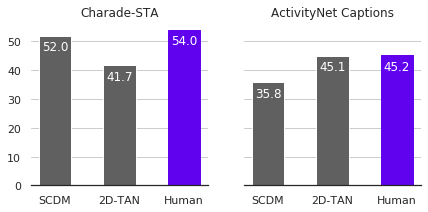

In [38]:
def display_score(bar, ax, top_margin=4,color="w"):
    ax.text(
        bar.get_x()+bar.get_width()*.5,
        bar.get_height()-top_margin,
        f"{bar.get_height():.1f}",
        horizontalalignment="center",
        fontsize=12,
        color=color
    )

sns.set_style("white")
f, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=True)
top_margin = 5
for ax, leaderboard in zip(axes, [charade_leaderboard, activitynet_leaderboard]):
    labels = list(leaderboard.keys())
    scores = list(leaderboard.values())
    n = len(labels)
#     sorted_idx = np.argsort(scores)
#     scores = [scores[i] for i in sorted_idx]
#     labels = [labels[i] for i in sorted_idx]
#     n = len(sorted_idx)
    
    bars = ax.bar(np.arange(n), scores, color="#606060", width=0.5)
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(labels)

    bars[2].set_color("#6002ee")
    
    for i, b in enumerate(bars):
        display_score(b, ax, top_margin, color="w")

    ax.yaxis.grid()
    
sns.despine(left=True)
axes[0].set_title("Charade-STA")
axes[1].set_title("ActivityNet Captions")
plt.savefig('reports/figures/performance_comparison/performance_SOTA_and_Human.pdf',
           bbox_inches='tight')